# Spatial Proteomics Analysis for CODEX Data

This tutorial provides a comprehensive guide to analyzing spatial proteomics data generated from CODEX (CO-Detection by indEXing) technology. We will cover the following steps:

1. Introduction to CODEX Data
2. Cell Segmentation Using Stardist and QuPath
3. Loading Measurements in Python and Performing Downstream Analysis

### QuPath for Visualization and Analysis
QuPath is an open-source software for bioimage analysis. It provides tools for visualizing and analyzing segmentation results.

Step-by-Step Guide to Using QuPath
Install QuPath:

1. Download and install QuPath from the [official website](https://qupath.github.io/).
2. Install [stardist](https://github.com/qupath/qupath-extension-stardist) for QuPath
3. Follow this [instruction](https://qupath.readthedocs.io/en/0.4/docs/deep/stardist.html) for cell segmentation



In [1]:
#TODO add data

In [2]:
from qimrtraining.utils import (Read_CODEX_QuPath,QC_plot_Protein,
                                preprocess_fluo, higher_z_score)
import pandas as pd
import stlearn as st
import anndata as ad
import numpy as np
from pathlib import Path
from PIL import Image
import seaborn as sns
import scanpy as sc
import monkeybread as mb
import sopa
import sopa.spatial
import networkx as nx
from community import community_louvain
from netgraph import Graph
from matplotlib import pyplot as plt
heatmap_kwargs = {"vmax": 40, "cmap": sns.cm.rocket_r, "cbar_kws": {'label': 'Mean hop distance'}}

/opt/anaconda3/envs/stimage2/lib/python3.10/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


### Load QuPath output into anndata format

In [3]:
DATA_PATH = Path().resolve().parent / "DATA/CODEX"
codex_path = DATA_PATH / "CODEX_01A_S05.txt"

In [4]:
library_id, adata = Read_CODEX_QuPath(codex_path, parent="tissue_3", library_id="S05_t3")

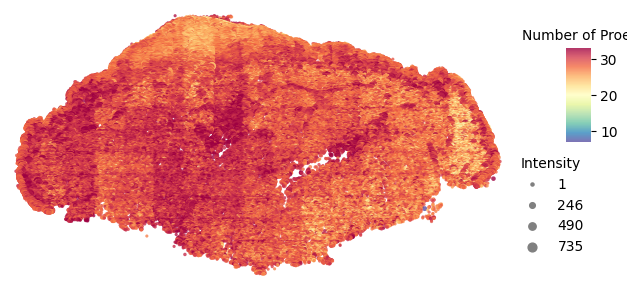

In [5]:
QC_plot_Protein(adata)

### Preprocessing

In [6]:
sc.pp.filter_cells(adata, min_counts=1)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata.copy()
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack", n_comps=20)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=0.3)
# adata.write(DATA_PATH / f"{library_id}_processed.h5ad")

2024-05-29 15:16:08.839547: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 15:16:08.843171: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 15:16:08.893171: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 15:16:08.893201: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 15:16:08.893223: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [7]:
# to save time, you can also load preprocessed data
adata = ad.read_h5ad(DATA_PATH / f"{library_id}_processed.h5ad")

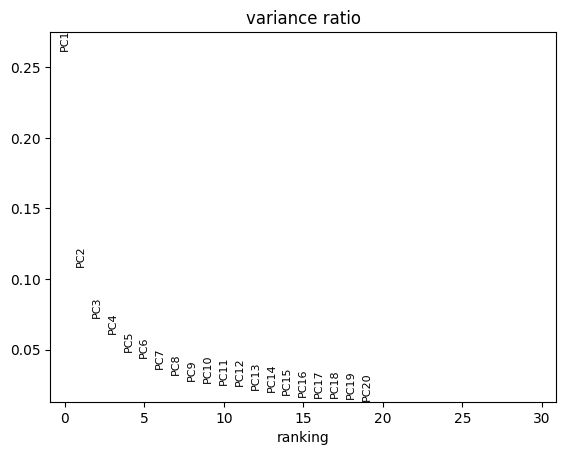

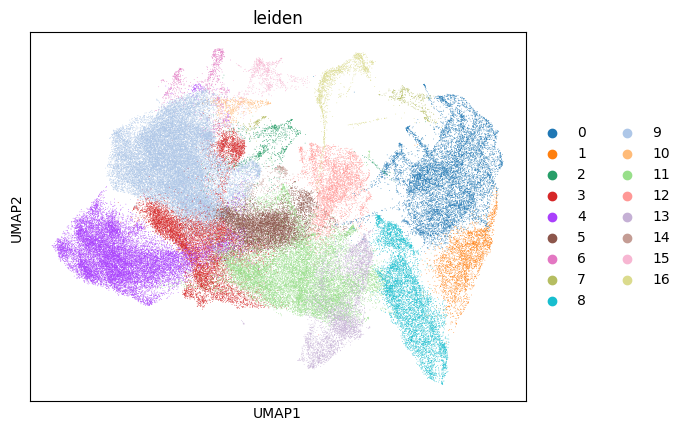

In [8]:
sc.pl.pca_variance_ratio(adata)
sc.pl.umap(adata, color="leiden")

### Marker based on annotation

In [9]:
marker_cell_dict ={'HLA-A': 'MHC I',
 'CD45': 'Leukocytes',
 'CD3e': 'T cells',
 'CD4': 'CTLs',
 'CD8': 'Th cells',
 'FOXP3': 'Treg cells',
 'GranzymeB': 'NKcs',
 'CD19': 'B cells',
 'CD20': 'B cells',
 'CD21': 'B cells',
 'CD11b': 'Inflammation',
 'MPO': 'Neutrophils',
 'CD68': 'Macrophages',
 'CD163': 'M2 macrophages/DCs',
 'CD11c': 'Phagocytes',
 'HLA-DR': 'MHC II',
#  'CD31': 'Blood vessels',
 'CD34': 'Blood vessels',
 'SMA': 'Blood vessels',
 'Podoplanin': 'Lymphatic vessels',
 'Keratin 14': 'Epithelium',
 'Pan-Cytokeratin': 'Epithelium',
 'Ki67': 'Proliferation',
#  'PD1': 'Immune checkpoint',
#  'PD-L1': 'Immune checkpoint',
#  'LAG3': 'Immune checkpoint',
#  'IDO1': 'Immune checkpoint',
 'PMEL': 'Melanoma',
#  'SOX10': 'Melanoma',
 'S100B': 'Melanoma',
#  'S100A4': 'Melanoma',
#  'HIF1A': 'Melanoma',
 'Vimentin': 'Fibroblasts'
 }

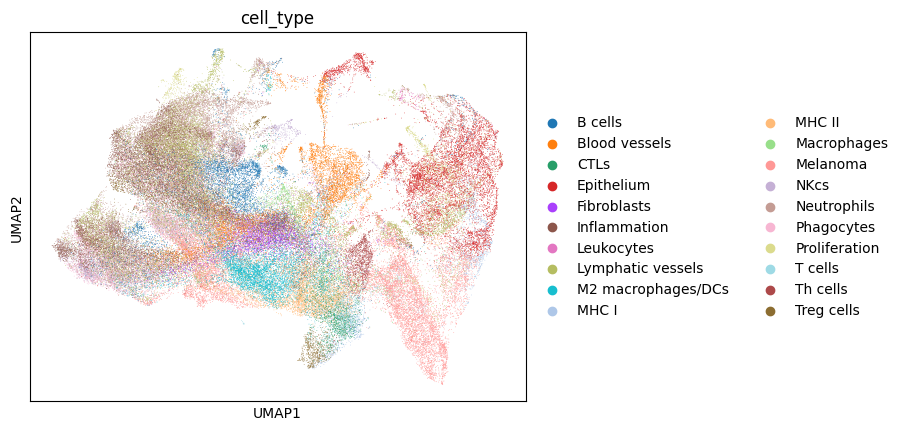

/opt/anaconda3/envs/stimage2/lib/python3.10/site-packages/stlearn/plotting/classes.py:733: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, cluster in enumerate(self.query_adata.obs.groupby(self.use_label)):


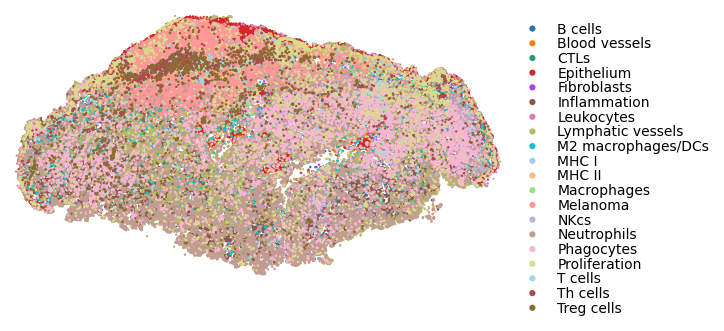

In [10]:
higher_z_score(adata, marker_cell_dict)
sc.pl.umap(adata, color="cell_type")
st.pl.cluster_plot(adata, use_label="cell_type", size=3)

### Niche analysis

In [11]:
niche_subtypes = []
other_cell_types = ['Blood vessels', "others"]
for cell, ct in zip(adata.obs.index, adata.obs['cell_type']):
    if ct in other_cell_types:
        niche_subtypes.append('Blood vessels/others')
    else:
        niche_subtypes.append(ct)
adata.obs['niche_subtypes'] = adata.obs['cell_type']
adata.obs['niche_subtypes'] = adata.obs['niche_subtypes'].astype('category')
adata.obsm["X_spatial"] = adata.obsm["spatial"]
print("Cell subtypes considered in niche analysis:")
print(set(adata.obs['niche_subtypes']))
# Compute niches
mask = ~adata.obs['niche_subtypes'].isin([
    'Blood vessels', "others"
])
adata_neighbors = mb.calc.cellular_niches(
    adata,
    cell_type_key='niche_subtypes',
    radius=75,
    normalize_counts=True,
    standard_scale=True,
    clip_min=-5,
    clip_max=5,
    n_neighbors=100,
    resolution=0.2,
    mask=mask,
    min_niche_size=300,
    key_added='niche',
    non_niche_value='Blood vessels/others'
)


Cell subtypes considered in niche analysis:
{'Treg cells', 'Th cells', 'Inflammation', 'M2 macrophages/DCs', 'Leukocytes', 'B cells', 'Melanoma', 'T cells', 'Phagocytes', 'MHC I', 'Proliferation', 'MHC II', 'Neutrophils', 'CTLs', 'Blood vessels', 'NKcs', 'Fibroblasts', 'Lymphatic vessels', 'Epithelium', 'Macrophages'}
Computing neighborhood profiles...


/opt/anaconda3/envs/stimage2/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Clustering neighborhood profiles...


/opt/anaconda3/envs/stimage2/lib/python3.10/site-packages/monkeybread/calc/_neighborhood_profile.py:246: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


Generating niches...


/opt/anaconda3/envs/stimage2/lib/python3.10/site-packages/stlearn/plotting/classes.py:723: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, cluster in enumerate(self.adata[0].obs.groupby(self.use_label)):
/opt/anaconda3/envs/stimage2/lib/python3.10/site-packages/stlearn/plotting/classes.py:733: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, cluster in enumerate(self.query_adata.obs.groupby(self.use_label)):


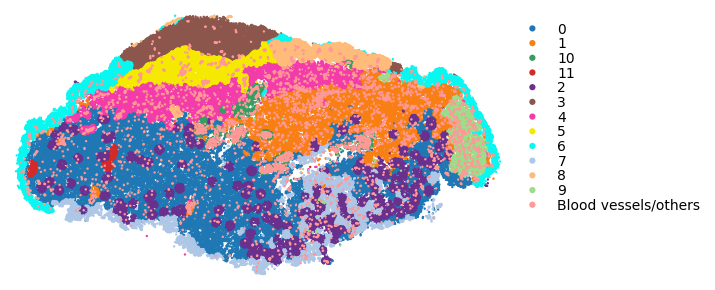

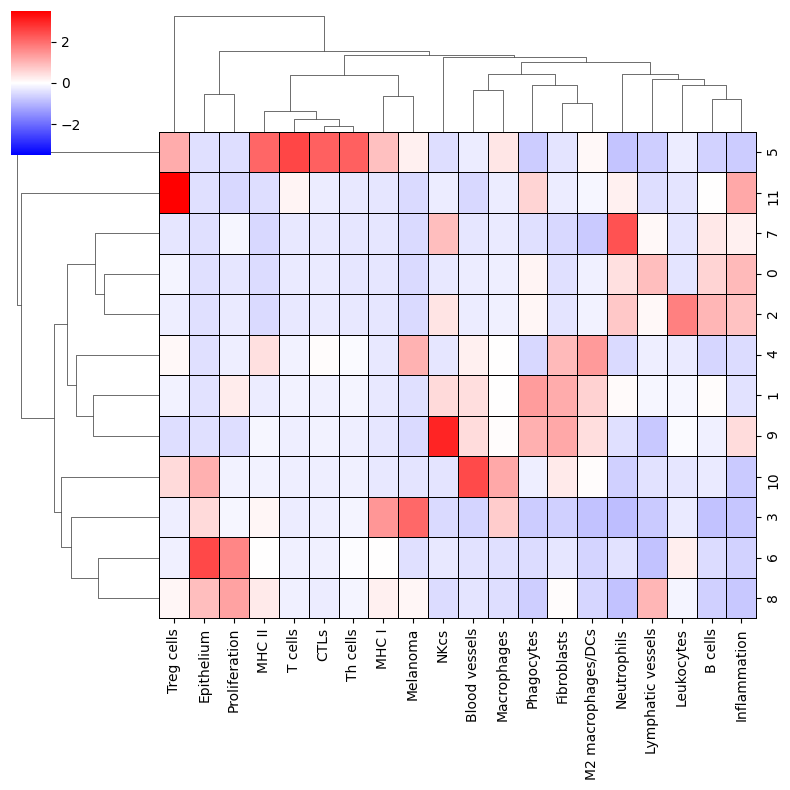

In [12]:
adata.obs["niche"] = pd.Categorical(adata.obs["niche"])
st.pl.cluster_plot(adata, use_label="niche", size=3)
mb.plot.neighbors_profile_matrixplot(
adata_neighbors,
'niche',
include_niches=[
    niche 
    for niche in set(adata_neighbors.obs['niche'])
    if niche != 'Blood vessels/others'
],
clustermap_kwargs={
    'linewidths': 0.5,
    'linecolor': 'black',
    'cmap': 'bwr',
    'clip_on': False,
    'vmin': -3.5,
    'vmax': 3.5,
    'figsize': (8,8)
}
)

In [13]:
annot_niche ={
    '0': "Immune_1", 
    '1': "Fibroblasts_1", 
    '10': "Epithelium_3", 
    '11': "Immune_2", 
    '2': "Immune_3", 
    '3': "Melanoma_3", 
    '4': "Fibroblasts_2", 
    '5': "Immune_4", 
    '6': "Epithelium_1", 
    '7': "Immune_5", 
    '8': "Epithelium_2", 
    '9': "Fibroblasts_3", 
    'Blood vessels/others' : "Blood vessels/others",
}
adata.obs["niche"] = adata.obs["niche"].map(annot_niche)

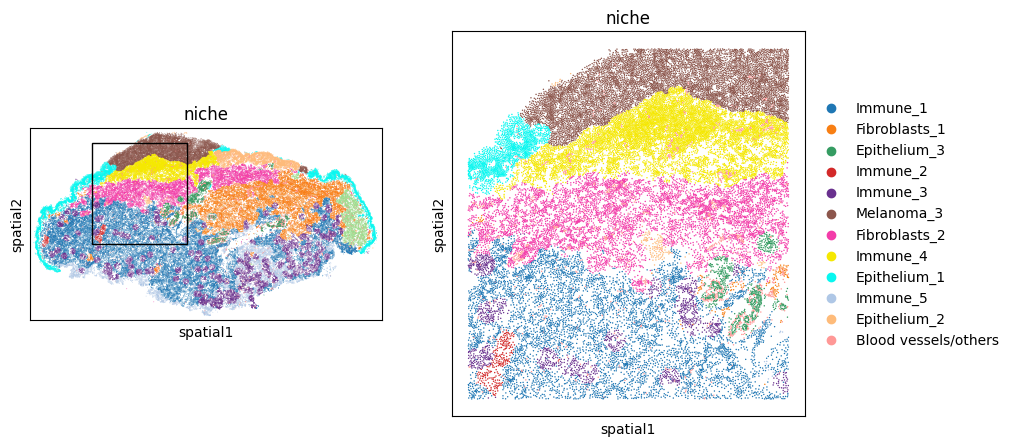

In [14]:
LEFT_PCT = 20
TOP_PCT = 40
WIDTH_PCT = 25
HEIGHT_PCT = 50
# Plot the niche
fig, axarr = plt.subplots(1,2,figsize=(10,5))
mb.plot.embedding_zoom(
    adata, 
    left_pct=LEFT_PCT,
    top_pct=TOP_PCT, 
    width_pct=WIDTH_PCT,
    height_pct=HEIGHT_PCT,
    color='niche', 
    basis='spatial', 
    show=False,
    axs=axarr
)
imagecol, imagerow = adata.obsm["spatial"][:,0],adata.obsm["spatial"][:,1]
axarr[0].imshow(adata.uns['spatial'][library_id]['images']['hires'])
margin=100
axarr[0].set_xlim(imagecol.min() - margin, imagecol.max() + margin)

axarr[0].set_ylim(imagerow.min() - margin, imagerow.max() + margin)

axarr[0].set_ylim(axarr[0].get_ylim()[::-1])
axarr[1].set_ylim(axarr[1].get_ylim()[::-1])
plt.show()

### co-localization between cell types (radius)

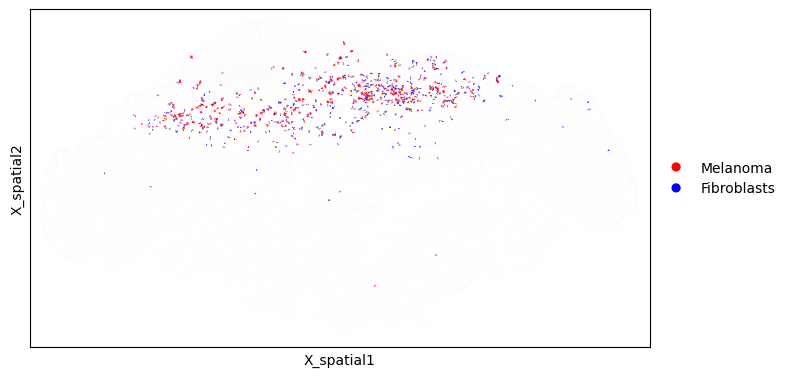

In [15]:
cell_to_neighbors = mb.calc.cell_neighbors(
    adata,
    groupby='cell_type',
    group1=['Melanoma'],
    group2=['Fibroblasts'],
    radius=20
) 

fig, ax = plt.subplots(figsize=(8, 8))
mb.plot.cell_neighbor_embedding(
    adata,
    cell_to_neighbors,
    palette=['Red', 'Blue'],
    group1_name='Melanoma',
    group2_name='Fibroblasts',
    dot_size_group1=2,
    dot_size_group2=2,
    show=False,
    ax=ax,
)
imagecol, imagerow = adata.obsm["spatial"][:,0],adata.obsm["spatial"][:,1]
plt.imshow(adata.uns['spatial'][library_id]['images']['hires'])
margin=100
ax.set_xlim(imagecol.min() - margin, imagecol.max() + margin)

ax.set_ylim(imagerow.min() - margin, imagerow.max() + margin)

ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

### Statistical test for co-localization between a pair of cell types

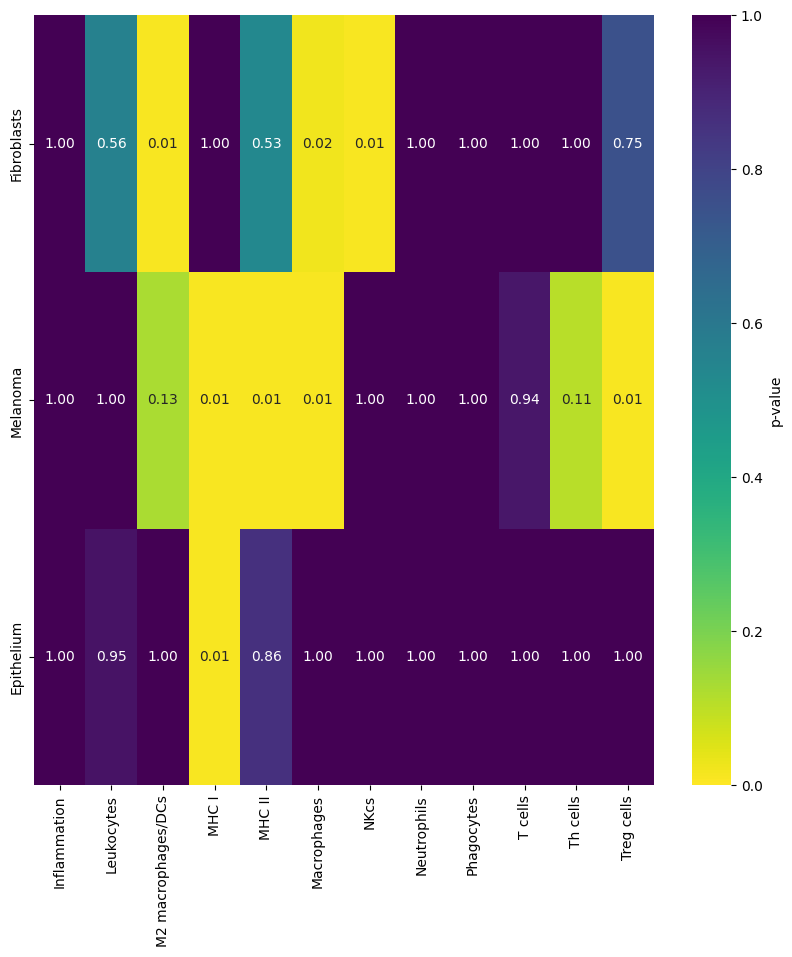

In [16]:
adata_test = adata.copy()

OTHER_SUBTYPES = [
    'Fibroblasts',
    'Melanoma', 
    'Epithelium',
]

IMMUNE_SUBTYPES = [
       'Inflammation', 'Leukocytes', 'M2 macrophages/DCs',
       'MHC I', 'MHC II', 'Macrophages', 'NKcs', 'Neutrophils',
       'Phagocytes', 'T cells', 'Th cells', 'Treg cells'
]

# Compute distance from each cell type to the nearest cell subtype
ct1_to_ct2_to_dists = mb.calc.shortest_distances_pairwise(
    adata_test, 
    'cell_type', 
    OTHER_SUBTYPES, 
    IMMUNE_SUBTYPES
)

# Calculate significance of these shortest distances
ct1_to_ct2_to_perms, ct1_to_ct2_to_pval = mb.stat.shortest_distances_pairwise(
    adata_test, 
    'cell_type', 
    OTHER_SUBTYPES, 
    IMMUNE_SUBTYPES,
    n_perms=100,
    observed=ct1_to_ct2_to_dists, 
    threshold=20
)


fig, ax = mb.plot.shortest_distances_pairwise(
    ct1_to_ct2_to_pval,
    order_x=IMMUNE_SUBTYPES,
    order_y=OTHER_SUBTYPES,
    figsize=(10,10),
    show=False
)

### co-localization between cell types (Delaunay graph)

In [17]:
sopa.spatial.spatial_neighbors(adata, radius=[0, 50])

[INFO] (sopa.spatial._build) Computing delaunay graph


100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


<Axes: xlabel='cell_type', ylabel='cell_type'>

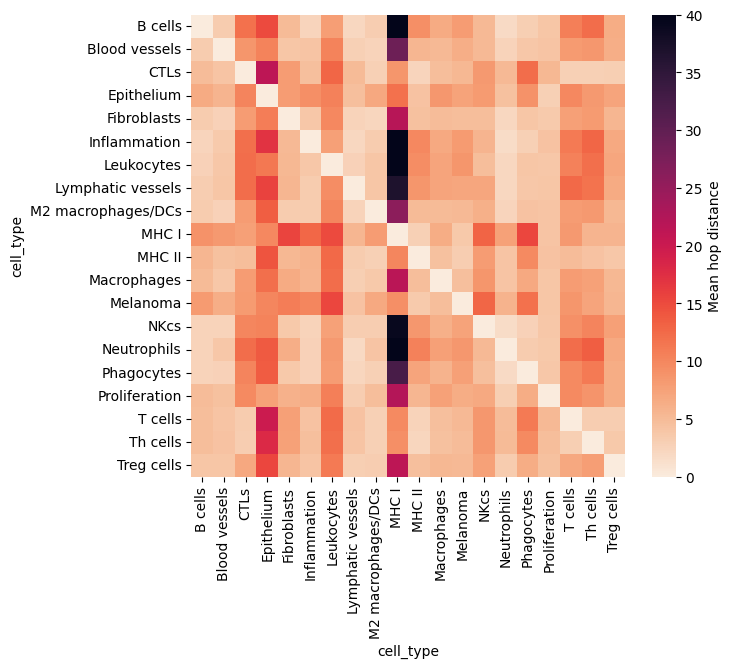

In [18]:
cell_type_to_cell_type = sopa.spatial.mean_distance(adata, "cell_type", "cell_type")
plt.figure(figsize=(7, 6))
sns.heatmap(cell_type_to_cell_type, **heatmap_kwargs)

100%|██████████| 13/13 [00:02<00:00,  6.09it/s]


<Axes: xlabel='niche', ylabel='cell_type'>

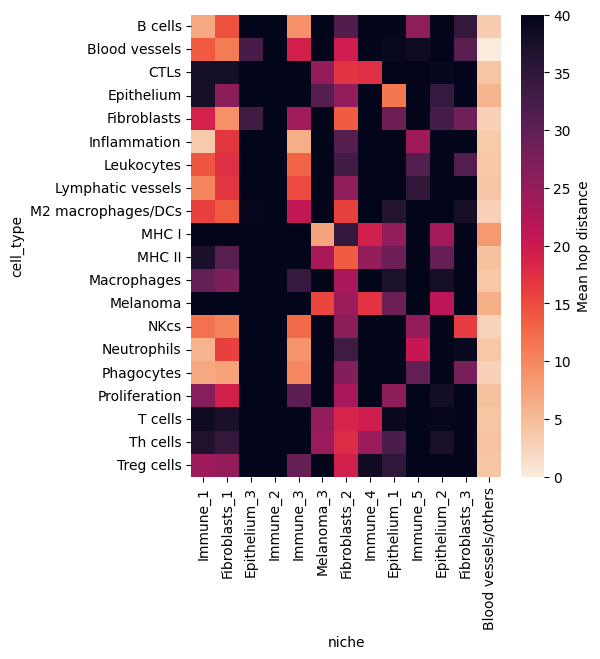

In [19]:
cell_type_to_niche = sopa.spatial.mean_distance(adata, "cell_type", "niche")
plt.figure(figsize=(5, 6))
sns.heatmap(cell_type_to_niche, **heatmap_kwargs)

100%|██████████| 13/13 [00:01<00:00,  8.15it/s]


<Axes: xlabel='niche', ylabel='niche'>

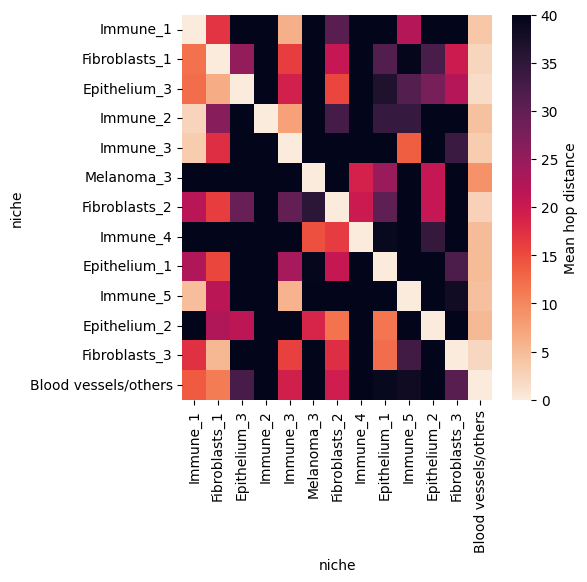

In [20]:
niche_to_niche = sopa.spatial.mean_distance(adata, "niche")
plt.figure(figsize=(5, 5))
sns.heatmap(niche_to_niche, **heatmap_kwargs)

### Niches geometries

In [21]:
df_niches_geometries = sopa.spatial.niches_geometry_stats(adata, "niche")
df_niches_geometries

[INFO] (sopa.spatial.morpho) Computing pairwise distances between 56 components


,n_components,length,area,roundness,min_distance_to_niche_Blood vessels/others,min_distance_to_niche_Epithelium_1,min_distance_to_niche_Epithelium_2,min_distance_to_niche_Epithelium_3,min_distance_to_niche_Fibroblasts_1,min_distance_to_niche_Fibroblasts_2,min_distance_to_niche_Fibroblasts_3,min_distance_to_niche_Immune_1,min_distance_to_niche_Immune_2,min_distance_to_niche_Immune_3,min_distance_to_niche_Immune_4,min_distance_to_niche_Immune_5,min_distance_to_niche_Melanoma_3
niche,,,,,,,,,,,,,,,,,
Blood vessels/others,18,675.064809,1.378314e+04,0.351583,0.000000,1333.448512,1505.360602,479.107951,577.219736,298.282676,3488.213178,330.533443,1967.203754,506.445047,759.488224,1081.672525,1172.910624
Epithelium_1,2,7982.213256,5.058919e+05,0.098024,351.054731,0.000000,1257.306879,1094.206422,887.771138,316.040023,2589.295013,9.427041,2450.064385,209.000698,1032.871597,322.571615,1059.287069
Epithelium_2,1,5044.378336,5.233203e+05,0.258441,262.195571,218.699267,0.000000,7.047006,12.595036,0.000000,1137.295771,909.323360,2995.644002,1279.786657,5.634198,1332.698754,31.356449
Epithelium_3,8,1216.340114,5.543033e+04,0.510727,64.608725,1598.290405,978.595298,0.000000,73.176736,301.850723,2723.350356,355.345362,2396.265591,488.531459,777.661915,871.767221,1184.297984
Fibroblasts_1,1,18051.360689,2.922374e+06,0.112700,0.000000,3.146911,12.595036,7.960373,0.000000,2.488421,0.000000,0.000000,1768.613154,0.000000,289.812002,5.477386,720.704702
Fibroblasts_2,2,7308.552771,9.207130e+05,0.223276,0.000000,316.040023,347.665553,5.926063,10.168173,0.000000,2317.305239,366.527322,1408.327634,577.905361,0.891945,1114.691583,186.741365
Fibroblasts_3,1,4224.656480,5.581030e+05,0.392954,1131.594280,0.000000,1137.295771,1146.888175,0.000000,1395.820624,0.000000,0.000000,5397.086177,11.180097,2859.518247,196.777805,2985.892767
Immune_1,2,29642.253548,2.828415e+06,0.035171,262.845034,9.427041,1107.013995,272.197923,0.000000,479.711848,1211.113303,0.000000,2231.210764,0.000000,1322.515599,3.746176,1617.927597
Immune_2,2,918.342128,3.547020e+04,0.545679,447.347340,449.617104,3651.921522,1996.113500,2447.008352,872.585264,6071.565113,0.378256,0.000000,179.763296,1300.061648,542.961410,1746.193534


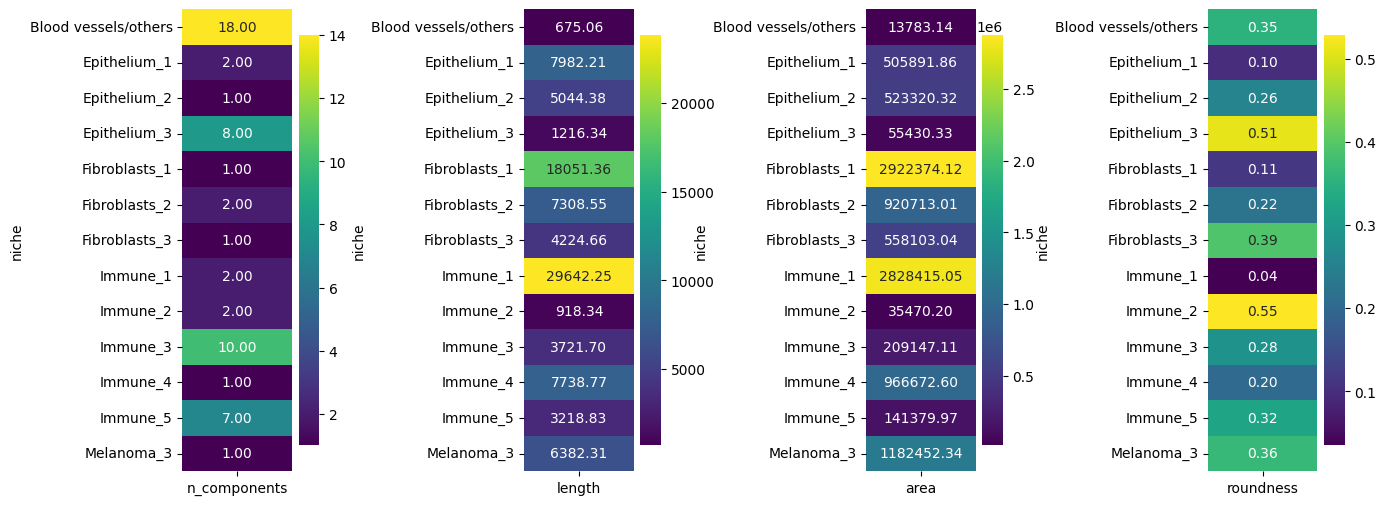

In [22]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

for i, name in enumerate(["n_components", "length", "area", "roundness"]):
    vmax = df_niches_geometries[name].sort_values()[-2:].mean()
    sns.heatmap(df_niches_geometries[[name]], cmap="viridis", annot=True, fmt=".2f", vmax=vmax, ax=axes[i])

plt.subplots_adjust(wspace=1.5)

### Niche Graph

In [23]:
weights, node_color, node_size, node_shape = sopa.spatial.prepare_network(adata, "cell_type", "niche")
g = nx.from_pandas_adjacency(weights)
node_to_community = community_louvain.best_partition(g, resolution=1.35)

[INFO] (sopa.spatial.distance) Computing all distances for the 4 pairs of categories
100%|██████████| 13/13 [00:01<00:00,  7.73it/s]


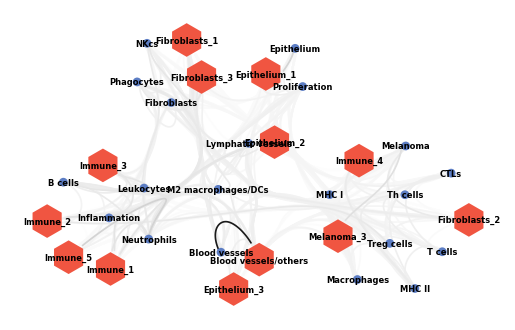

In [24]:
Graph(g,
      node_size=node_size,
      node_color=node_color,
      node_shape=node_shape,
      node_edge_width=0,
      node_layout='community',
      node_layout_kwargs=dict(node_to_community=node_to_community),
      node_labels=True,
      node_label_fontdict=dict(size=6, weight="bold"),
      edge_alpha=1,
      edge_width=0.5,
      edge_layout_kwargs=dict(k=2000),
      edge_layout='bundled',
)